In [41]:
from astropy.io import ascii
import matplotlib.pyplot as plt
import numpy as np

In [42]:
#Master file output
data = ascii.read("FishVBM_Therr_m20_2_52.out")
event_126 = data[data["EventID"] == 126]
print(event_126)

EventID SubRun Field ... ObsGroup_0_Fbase2_err ObsGroup_0_fs2_err LCOutput
------- ------ ----- ... --------------------- ------------------ --------
    126      2    52 ...     0.000948879943335  0.001267401531059        1


In [43]:
#LightCurve file
lc_data = ascii.read("FishVBM_Therr_m20_2_52_126.det.lc")

In [44]:
#Parameters file
def parse_prm_file(filepath):
    params = {}
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith("#") or "=" not in line:
                continue
            key, value = line.split("=", 1)
            params[key.strip()] = value.strip()
    return params

params = parse_prm_file("FVBM_m20.prm")

print(params)

sim_zero_time = float(params["SIMULATION_ZERO_TIME"])

{'RUN_NAME': 'FishVBM_Therr_m20', 'OUTPUT_DIR': '/work/fzohrabi/gulls_output/test/', 'FINAL_DIR': '/work/fzohrabi/gulls_output/test/', 'EXECUTABLE': 'gullsFish.x', 'OBSERVATORY_DIR': 'observatories/', 'OBSERVATORY_LIST': 'Roman_test_WZK.list', 'WEATHER_PROFILE_DIR': 'weather/', 'STARFIELD_DIR': 'starfields/', 'STARFIELD_LIST': 'gulls_surot2d_H2023.starfields', 'SOURCE_DIR': 'sources/', 'SOURCE_LIST': 'gulls_surot2d_H2023.sources', 'SOURCE_COLOURS': '0', 'LENS_DIR': 'lenses/', 'LENS_LIST': 'gulls_surot2d_H2023.lenses', 'LENS_COLOURS': '0', 'LENS_LIGHT': '1', 'PLANET_DIR': 'planet/m+20/', 'PLANET_ROOT': 'm+20.planets.', 'RATES_FILE': 'rates/src_gulls_surot2d_H2023.rates.v2', 'PRINCIPLE_OBSERVATORY': '0', 'OUTPUT_LC': '1', 'OUTPUT_IMAGES': '0', 'PRETTY_PICS': '0', 'PRETTY_PICS_DIMENSIONS': '128', 'OUTPUT_ONERR': '0', 'OUTPUT_ONDET': '1', 'OUTPUT_ONALL': '0', 'OUTPUT_FISH': '1', 'IDEAL_PHOTOMETRY': '-1', 'PARALLAX': '1', 'OBS_GROUPS': '(0,1,2)', 'NOBS': '3', 'NOBS_GROUPS': '1', 'OBS_GROUP_

# Sanity Check

In [45]:
#from .out file
row = event_126[0]  
t0_ref = row["t0lens1"]
tE = row["tE_ref"]
rho = row["rho"]
u0_list = [row["u0lens1"]]
alpha = row["alpha"]
q = row["Planet_q"]
s = row["Planet_s"]

t0 = abs(t0_ref - sim_zero_time)

In [46]:
#manually from data available from the .lc file
mask = lc_data['col6'] == 0 #0 is the data we need

# Extract positions
source_x = lc_data['col12'][mask]
source_y = lc_data['col13'][mask]
lens1_x = lc_data['col14'][mask]
lens1_y = lc_data['col15'][mask]
lens2_x = lc_data['col16'][mask]
lens2_y = lc_data['col17'][mask] 
bjd = lc_data["col11"][mask]



#Extract flux
flux = lc_data["col4"][mask]
flux_error = lc_data["col5"][mask]
#s
s_lc = lens2_x[0] - lens1_x[0]

#distance to lens
dist = np.sqrt((source_x - lens1_x)**2 + (source_y - lens1_y)**2)

#t0: time of closest approach
idx_min = np.argmin(dist)
t0_lc = bjd[idx_min]

#tE
ds = np.sqrt((source_x[-1] - source_x[0])**2 + (source_y[-1] - source_y[0])**2)
dt = bjd[-1] - bjd[0]
v = ds / dt
tE_lc = 1.0 / v  # in days

#tau
tau_lc = (bjd - t0_lc) / tE_lc

#alpha
dx = source_x[-1] - source_x[0]
dy = source_y[-1] - source_y[0]
alpha_rad = np.arctan2(dy, dx)
alpha_deg = np.degrees(alpha_rad) % 360  
alpha_flipped = (alpha_deg + 180) % 360

#u0 parameter
x0 = source_x[len(source_x) // 2]
y0 = source_y[len(source_y) // 2]

numerator = (dx * y0 - dy * x0)
denominator = np.sqrt(dx**2 + dy**2)
u0_lc = numerator / denominator

In [47]:
print(f'Estimated s = {s_lc:.6},', f'GULLS output s={s}')
print(f'Estimated t0 = {t0_lc:.10},', f'GULLS output t0={t0}')
print(f'Estimated tE = {tE_lc:.6},', f'GULLS output tE={tE}')
print(f"Estimated alpha = {alpha_deg:.4f} degrees,", f'GULLS output alpha={alpha}')
print(f"Estimated u0 = {u0_lc:.6f},", f'GULLS output u0={u0_list}')

Estimated s = 1.34777, GULLS output s=1.347771197642
Estimated t0 = 2458261.929, GULLS output t0=2458206.0703329355
Estimated tE = 4.40305, GULLS output tE=4.403168559902
Estimated alpha = 274.3129 degrees, GULLS output alpha=274.3131637573
Estimated u0 = -0.086032, GULLS output u0=[np.float64(-0.08453353201416)]


# Plotting GULLS

Text(0, 0.5, 'Y')

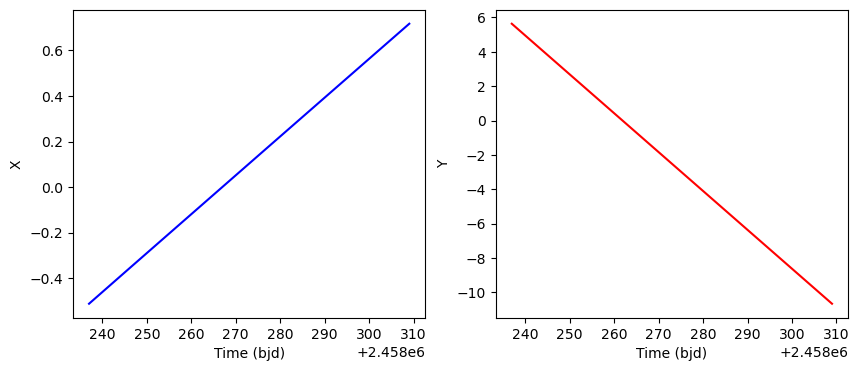

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(bjd, source_x, color='blue')
axs[0].set_title('')
axs[0].set_xlabel('Time (bjd)')
axs[0].set_ylabel('X')

axs[1].plot(bjd, source_y, color='red')
axs[1].set_title('')
axs[1].set_xlabel('Time (bjd)')
axs[1].set_ylabel('Y')

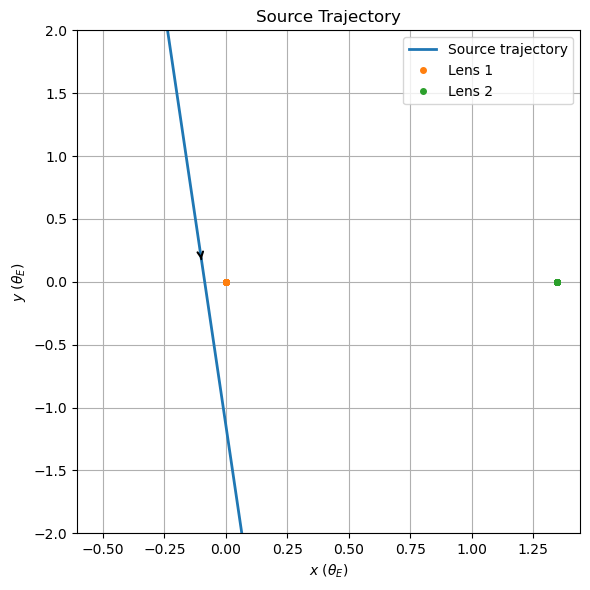

In [49]:
plt.figure(figsize=(6,6))

plt.plot(source_x, source_y, lw=2, label='Source trajectory')

# Annotate with an arrow from some point to a later point
start_idx = len(source_x) // 3
end_idx = start_idx + 20  # adjust the offset for the arrow length

plt.annotate(
    '', 
    xy=(source_x[end_idx], source_y[end_idx]), 
    xytext=(source_x[start_idx], source_y[start_idx]),
    arrowprops=dict(arrowstyle="->", lw=1.5 )
)

plt.plot(lens1_x, lens1_y, 'o', label="Lens 1", markersize=4)
plt.plot(lens2_x, lens2_y, 'o', label="Lens 2", markersize=4)

plt.ylim(-2,2)
plt.xlabel(r"$x$ ($\theta_E$)")
plt.ylabel(r"$y$ ($\theta_E$)")
plt.title("Source Trajectory")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Comparing Model

In [50]:
from ML import TwoLens1S
model = TwoLens1S(t0=t0_lc, tE=tE, rho=rho, u0_list=u0_list, q=q, s=s, alpha=alpha, t_lc=bjd)
model2 = TwoLens1S(t0=t0_lc, tE=tE_lc, rho=rho, u0_list=[u0_lc], q=q, s=s_lc, alpha=alpha_flipped, t_lc=bjd)

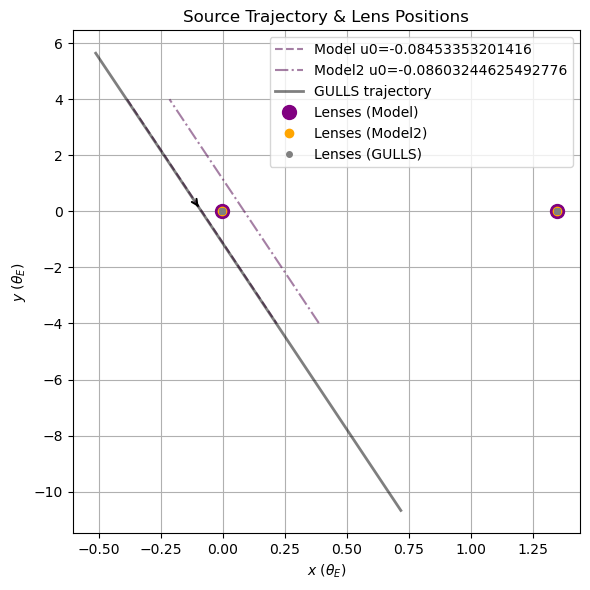

In [51]:
plt.figure(figsize=(6,6))

# Plot trajectory from your first model
for system in model.systems:
    plt.plot(system['x_src'], system['y_src'], '--', color=system['color'], lw=1.5, label=f"Model u0={system['u0']}", alpha=0.5)

# Plot trajectory from your second model
for system2 in model2.systems:
    plt.plot(system2['x_src'], system2['y_src'], '-.', color=system2['color'], lw=1.5, label=f"Model2 u0={system2['u0']}", alpha=0.5)

# Plot GULLS trajectory
plt.plot(source_x, source_y, lw=2, label='GULLS trajectory', color='black', alpha=0.5)

# Annotate arrow for GULLS path
start_idx = len(source_x) // 3
end_idx = start_idx + 20
plt.annotate(
    '', 
    xy=(source_x[end_idx], source_y[end_idx]),
    xytext=(source_x[start_idx], source_y[start_idx]),
    arrowprops=dict(arrowstyle="->", lw=1.5, color='black')
)

# Plot lens positions from your models
x1_model = -model.s * model.q / (1 + model.q)
x2_model = model.s / (1 + model.q)
plt.plot([x1_model, x2_model], [0, 0], 'o', color='purple', label='Lenses (Model)', markersize = 10)

x1_model2 = -model2.s * model2.q / (1 + model2.q)
x2_model2 = model2.s / (1 + model2.q)
plt.plot([x1_model2, x2_model2], [0, 0], 'o', color='orange', label='Lenses (Model2)')

# Also plot GULLS lens positions for direct comparison
plt.plot(lens1_x, lens1_y, 'o', color='grey', markersize=4, label="Lenses (GULLS)")
plt.plot(lens2_x, lens2_y, 'o', color='grey', markersize=4)

#plt.ylim(-3, 3)
plt.xlabel(r"$x$ ($\theta_E$)")
plt.ylabel(r"$y$ ($\theta_E$)")
plt.title("Source Trajectory & Lens Positions")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [52]:
model2.animate()

/Users/gregcc/Documents/GitHub/SURP25/Microlensing/ML.py:385: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(loc='lower right')


In [53]:
model_tau = model.tau_lc
model_mag = model.systems[0]["mag"]

model2_tau = model2.tau_lc
model2_mag = model2.systems[0]["mag"]

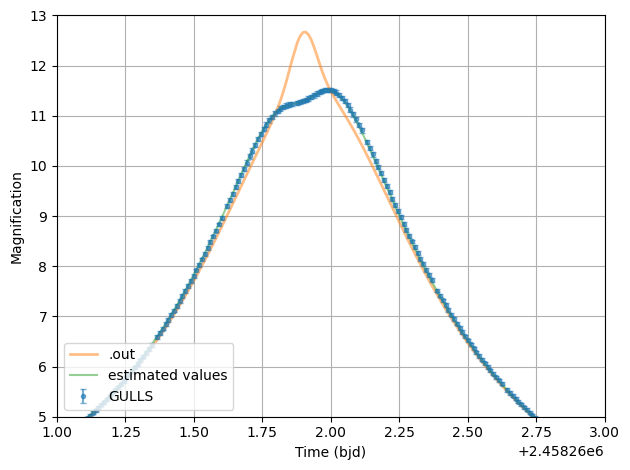

In [66]:
fs = 0.41432
magnification = (flux - (1 - fs)) / fs

sigma_mag = flux_error / fs

plt.errorbar(bjd, magnification, yerr=sigma_mag, fmt='.', label='GULLS', alpha=0.6, capsize=2)
plt.plot(bjd, model_mag, label=".out", lw=2, alpha=0.5)
plt.plot(bjd, model2_mag, label ="estimated values", alpha =.5)
plt.xlabel("Time (bjd)")
plt.ylabel("Magnification")

plt.ylim(5, 13)
plt.xlim(261+2.458e6, 263+2.458e6)

plt.legend(loc = 'lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

(2458260.0, 2458265.0)

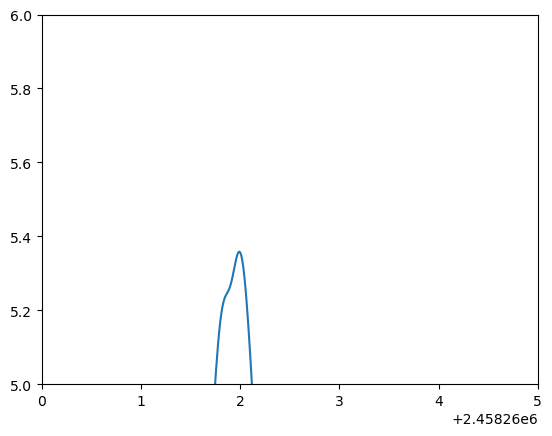

In [55]:
plt.plot(bjd, flux)
plt.axhline(1, ls='--', color='gray')


plt.ylim(5,6)
plt.xlim(260+2.458e6, 265+2.458e6)

# Astrometry 

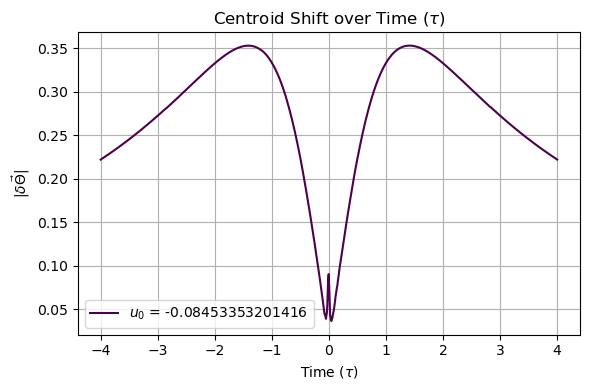

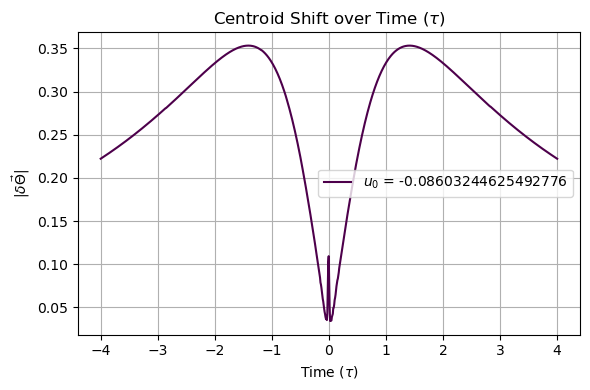

In [56]:
model.plot_centroid_shift()
model2.plot_centroid_shift()

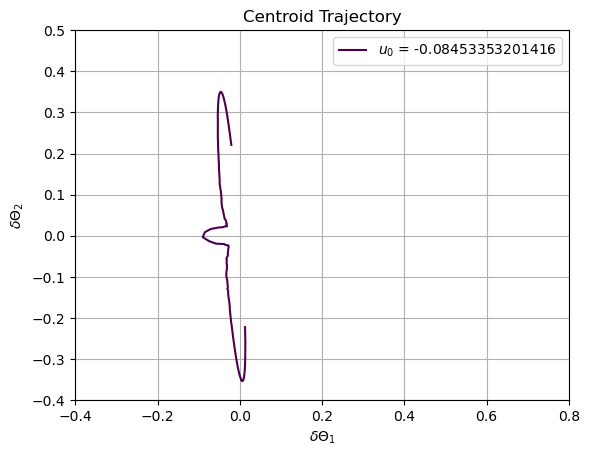

In [57]:
model.plot_centroid_trajectory()

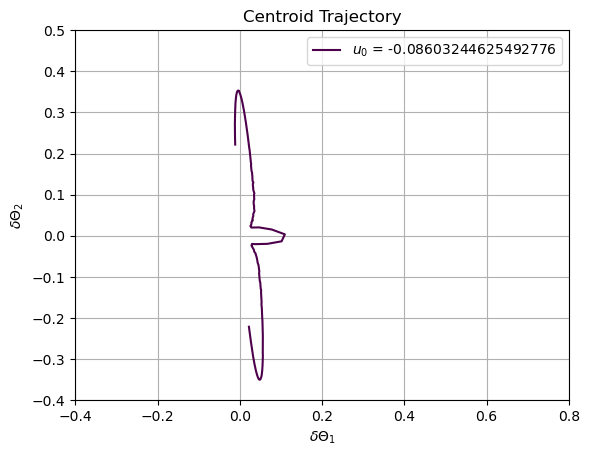

In [58]:
model2.plot_centroid_trajectory()

# Checking with VBM

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import VBMicrolensing


mpl.rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 20

%matplotlib inline

# Better looking figures
%config InlineBackend.figure_format = 'retina'

In [76]:
# Initialize VBMicrolensing() class object
VBM = VBMicrolensing.VBMicrolensing()
#Set relative accuracy
VBM.RelTol = 1e-03
#Set accuracy
VBM.Tol=1e-03

u0=-0.086032
t=bjd

In [77]:
params = [np.log(s), np.log(q), u0, alpha, np.log(rho), np.log(tE), t0]
mag = VBM.BinaryLightCurve(params, t)

In [78]:
# Calculate the cirtical curves and the caustic curves
caustics = VBM.Caustics(s,q)

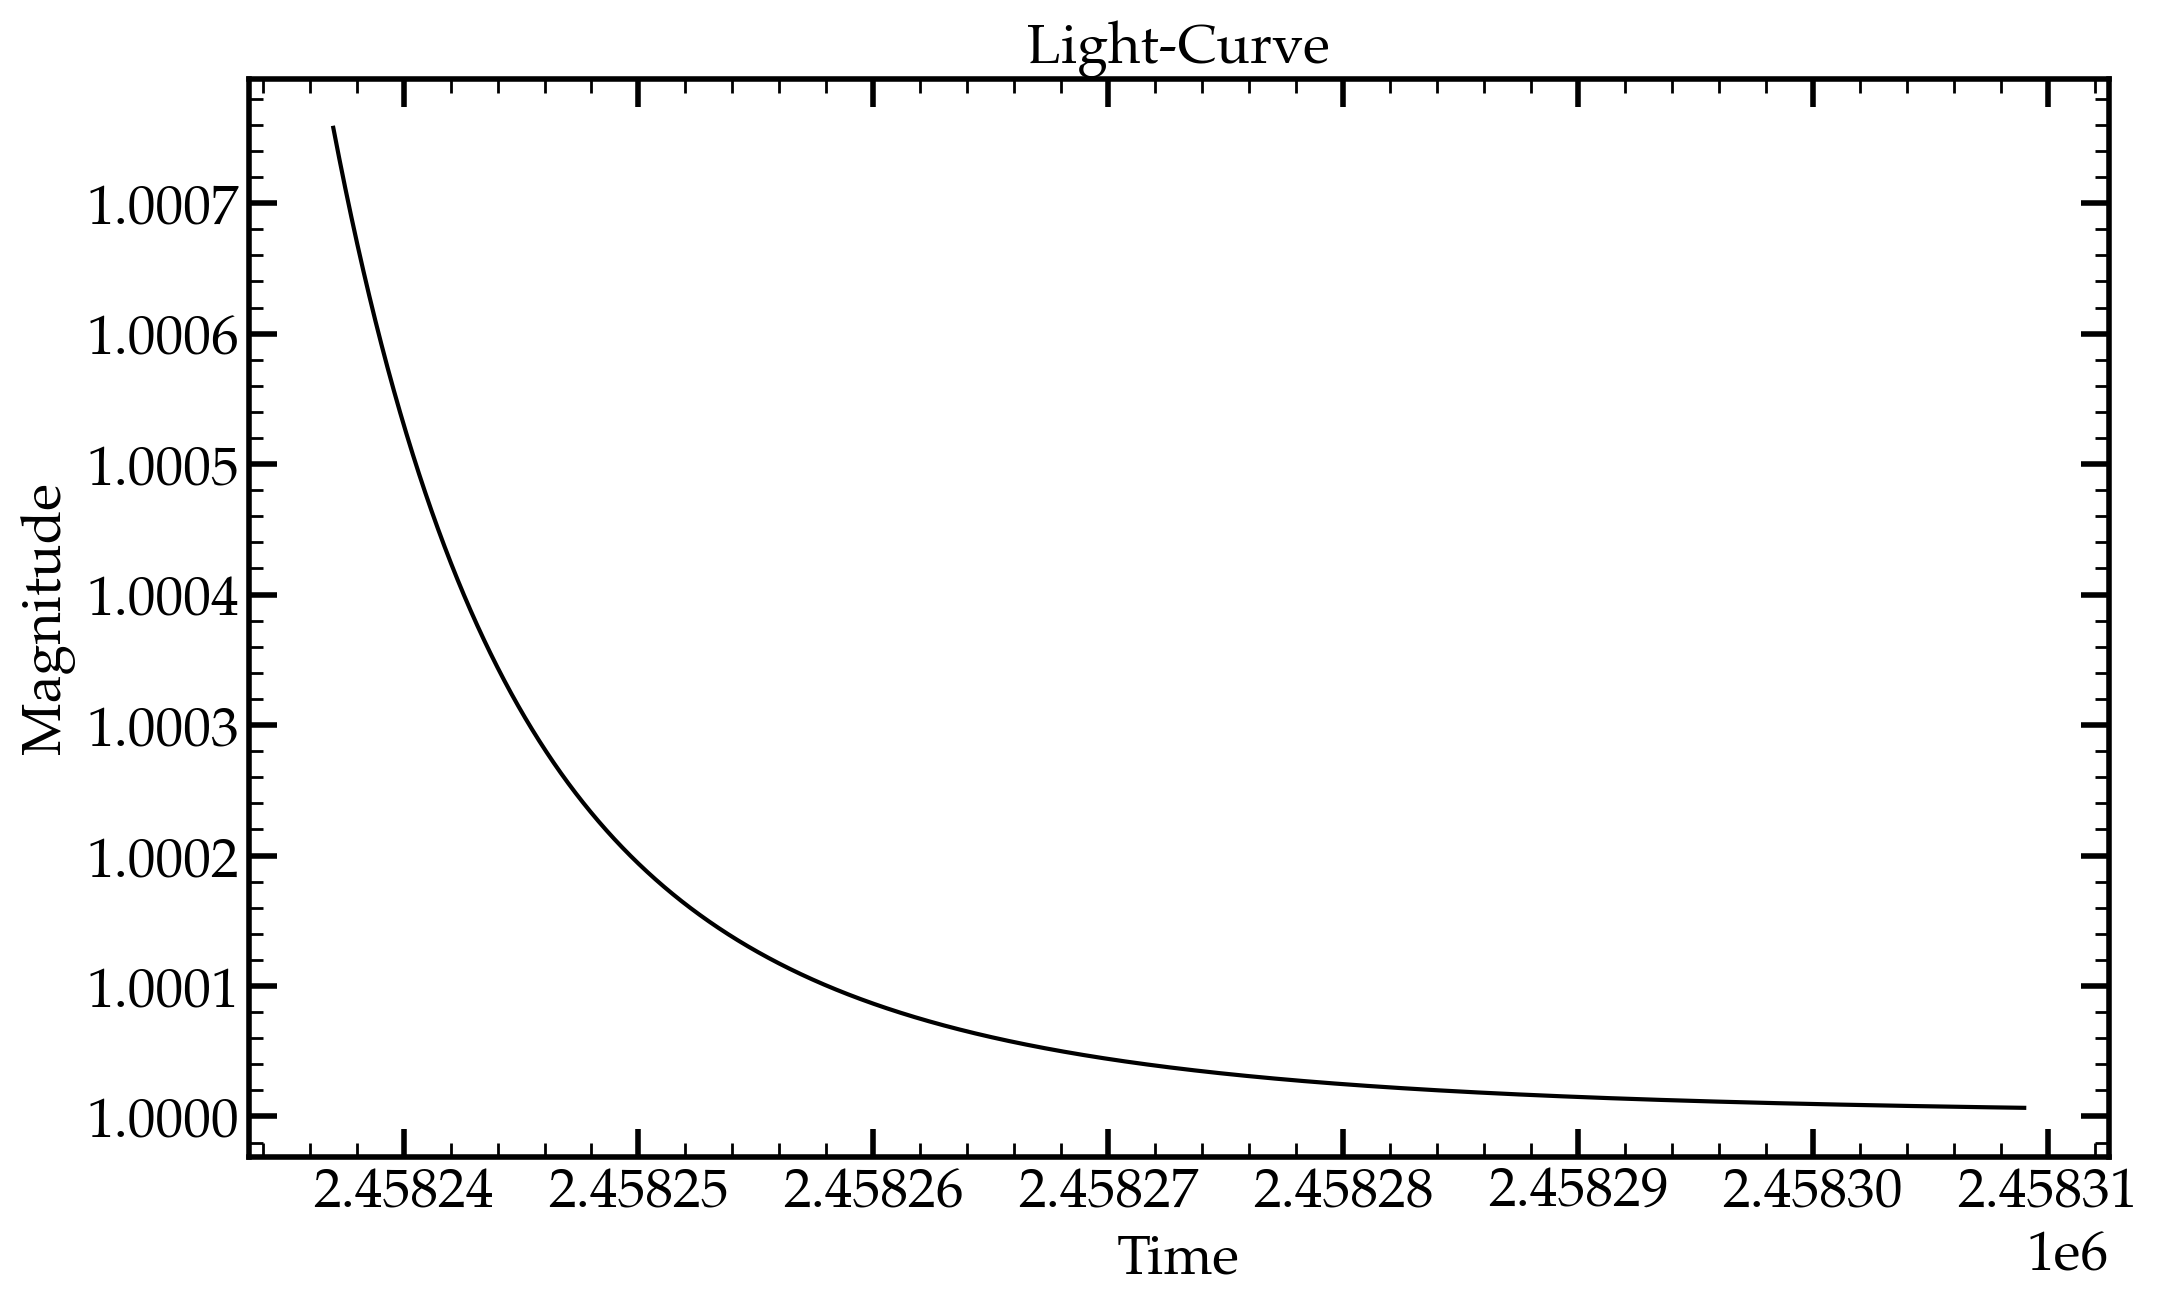

In [83]:
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = False  # make sure no LaTeX

fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(t, mag[0], 'k-')  # your data vs time

ax.set_title('Light-Curve')
ax.set_xlabel('Time')
ax.set_ylabel('Magnitude')

ax.minorticks_on()
ax.ticklabel_format(useOffset=False)  # turn off offset like +2.458e6

# ticks styling
ax.tick_params(axis='both', which='major', width=2, length=10, direction='in', bottom=True, top=True, left=True, right=True)
ax.tick_params(axis='both', which='minor', width=1, length=5, direction='in', bottom=True, top=True, left=True, right=True)

# border styling
for spine in ax.spines.values():
    spine.set_linewidth(2)

plt.show()
